# Timeseries analysis of temperature

* **Products used:** 
[ERA5](https://registry.opendata.aws/ecmwf-era5/)

This dataset is external to the Digital Earth Africa platform.

## Background

Timeseries decomposition can help us visualise long-term trends in geospatial variables. The technique decomposes a timeseries into its cyclical, trend, and residual error components. 

## Description
For this example, we will load air temperature data for Cairo, Egypt, then calculate the spatial average to generate a one-dimensional timeseries.

The notebook outlines:

1. Loading ERA5 temperature data.
2. Decomposing a timeseries.
3. Plotting and interpreting seasonal and trend components of timeseries.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from deafrica_tools.plotting import display_map
from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
!pip install statsmodels --upgrade
from statsmodels.tsa.seasonal import seasonal_decompose

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Timeseries_temperature")

### Analysis parameters

We will load temperature data for a forty year period (1981-2021) for the city of Cairo, Egypt.

The following cell sets important parameters for the analysis:

* `lat`: range of latitude we wish to cover.
* `lon`: range of longitude we wish to cover.
* `time`: time period

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.


In [3]:
# Area around Cairo
lat = (29.66, 30.32)
lon = (30.70, 31.46)

# Define the time window
time = '2013-01', '2021-12'

display_map(x = lon, y= lat)

## Load temperature data

We will use the `load_era5` function to get air temperature at a height of 2m for the period and area of interest. We resample this dataset to monthly mean values as we load, so the dataset size is more manageable.

We will also use `load_ard` to get land surface temperature from Landsats 7 and 8.

### Load air temperature

In [4]:
var = 'air_temperature_at_2_metres'

temp = load_era5(var, lat, lon, time, reduce_func=np.mean, resample='1M').compute()

In [5]:
attrs = temp[var].attrs
attrs['units']='C'
temp = temp - 273.15 # convert from Kelvin to Celcius
temp[var].attrs = attrs

### Load Landsat surface temperature

In [6]:
surf_temp = load_ard(dc=dc,
               products=['ls7_st','ls8_st'],
               x=lon,
               y=lat,
               time=time,
               measurements = ['surface_temperature'],
               output_crs = 'EPSG:32633',
               resolution = (-30, 30),
            dask_chunks={'x': 3000, 'y': 3000})

surf_temp = surf_temp.resample(time='1M').mean() # resample to monthly mean values, as per air temperature data
print(surf_temp)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls7_st
    ls8_st


/home/jovyan/Tools/deafrica_tools/datahandling.py:474: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  pq_mask = xr.ufuncs.logical_or(pq_mask, pq_mask)
/env/lib/python3.8/site-packages/xarray/core/dataarray.py:3088: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/env/lib/python3.8/site-packages/xarray/core/variable.py:2420: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 1140 time steps as a dask array
<xarray.Dataset>
Dimensions:              (time: 108, y: 2845, x: 2851)
Coordinates:
  * time                 (time) datetime64[ns] 2013-01-31 ... 2021-12-31
  * y                    (y) float64 3.472e+06 3.472e+06 ... 3.387e+06 3.386e+06
  * x                    (x) float64 2.019e+06 2.019e+06 ... 2.104e+06 2.104e+06
    spatial_ref          int32 32633
Data variables:
    surface_temperature  (time, y, x) float32 dask.array<chunksize=(1, 2845, 2851), meta=np.ndarray>


Collapse the spatial dimensions of the Landsat surface temperature to produce a monthly timeseries.

In [7]:
surf_temp = surf_temp.dropna(dim='time', how='all')
surf_temp['surface_temperature'] = surf_temp.surface_temperature - 273.15
surf_temp_ts = surf_temp.groupby('time').mean(dim=xr.ALL_DIMS)

/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Below, the observed timeseries is plotted. Are there any noticeable trends or anomalies?

/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


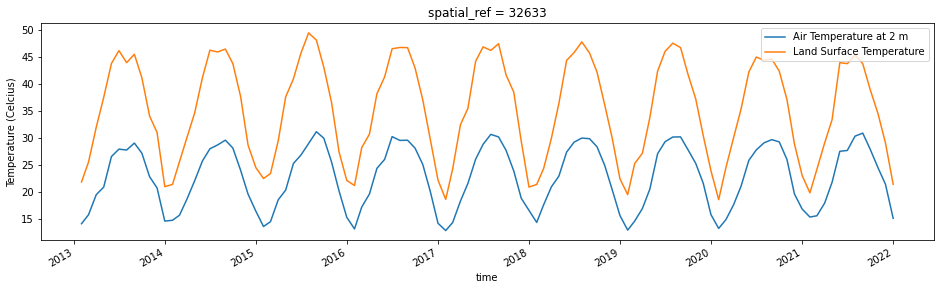

In [8]:
temp[var].mean(['lat','lon']).plot(figsize = (16,4),label='Air Temperature at 2 m');
surf_temp_ts.surface_temperature.plot(label='Land Surface Temperature');
plt.ylabel('Temperature (Celcius)')
plt.legend()

## Timeseries decomposition

The next step is to decompose the observed timeseries into its seasonal and trend components. The `seasonal_decompose` function works best on pandas timeseries, so we will spatially aggregate our timeseries and convert it to a pandas dataframe.

In [9]:
temp_air_ts = temp[var].mean(['lat','lon']).to_pandas()
temp_surf_ts = surf_temp_ts['surface_temperature'].to_pandas().asfreq('M').dropna()

/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Now we can use the `seasonal_decompose` function on our timeseries. Details on the function are available in the [package notes](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) and general timeseries decomposition is available [here](https://en.wikipedia.org/wiki/Decomposition_of_time_series).

The result of decomposition is plotted below which shows the observed timeseries (shown above), the trend component (note difference in y-axis scale), the seasonal (or cyclical) component, and the residual error.

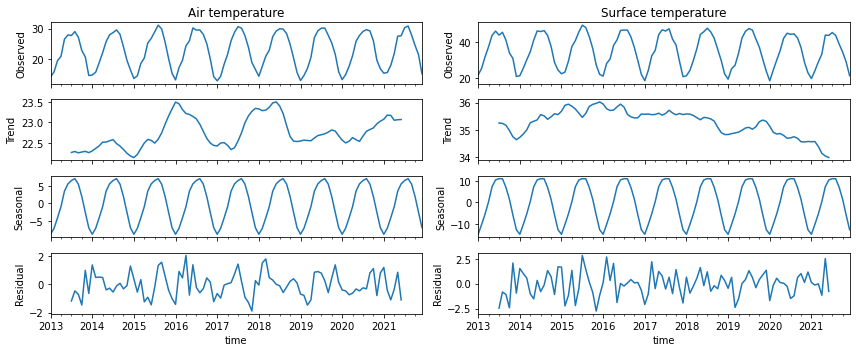

In [10]:
temp_air_dts = seasonal_decompose(temp_air_ts)
temp_surf_dts = seasonal_decompose(temp_surf_ts)

def plotseasonal(res, axes, title):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(title)
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(temp_air_dts, axes[:,0], title='Air temperature')
plotseasonal(temp_surf_dts, axes[:,1], title='Surface temperature')

plt.tight_layout()
plt.show();

We can also plot individual components, such as the long term trend, as below, and make comparisons between air and surface temperature. 

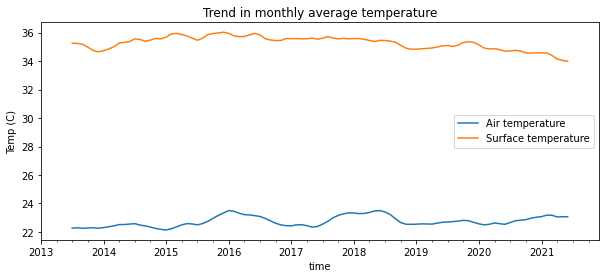

In [11]:
temp_air_dts.trend.plot(figsize = (10,4), label='Air temperature')
plt.xlabel('Year')
plt.ylabel('%s (%s)'%('Temp', temp[var].attrs['units']))
temp_surf_dts.trend.plot(label='Surface temperature')
plt.title('Trend in monthly average temperature')
plt.legend()

## Interpretation and next steps

The exploratory analysis conducted in this notebook allows us to visually examine trends and seasonal patterns. We would need to conduct further statistical test to determine whether any observed trends could be considered 'significant'. 

We are also unable to draw any causal inferences about observed trends from this analysis alone. We might hypothesise that the increasing air temperature trend is due to increasing atmospheric greenhouse gas concentration, and we could hypothesise that decreasing land surface temperature trends could be due to changes in vegetation cover or medium-term climate influences.

Further analysis would be required to attribute the trends to any of these factors. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-05-12'